In [1]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

In [2]:
# 0 : pas de frande liée à une transaction
# 1 :  frande liée à une transaction

# https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [1]:
import numpy as np
import pandas as pd
import datatable as dt  # pip install git+https://github.com/h2oai/datatable
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import bctools as bc # pip install git+https://github.com/lucazav/binclass-tools
import seaborn as sns
from joblib import dump, load
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/ying/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ying/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


# Télécharger les données

In [2]:
train_df = dt.fread('train_df.csv', sep=',').to_pandas()
test_df= dt.fread("test_df.csv", sep=",").to_pandas()
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Train shape: (307507, 798), test shape: (48744, 798)


## Vérifier les valeurs manquantes
- la proportion des valeurs manquantes
- la proportion des `TARGET` et `CODE_GENDER`
- Un diagramme pour afficher les `TARGET` 

In [3]:
# Les valeurs manquantes sur les colonnes
missing_props = train_df.isna().mean(axis=0)
missing_value_df = pd.DataFrame({'column_name': train_df.columns,
                                 'proportion_missing': missing_props
                                 } )
missing_value_df.sort_values(by='proportion_missing', ascending=False) #,key= lambda x: x>0.5) 

column_name  \
REFUSED_AMT_DOWN_PAYMENT_MEAN    REFUSED_AMT_DOWN_PAYMENT_MEAN   
REFUSED_RATE_DOWN_PAYMENT_MEAN  REFUSED_RATE_DOWN_PAYMENT_MEAN   
REFUSED_RATE_DOWN_PAYMENT_MAX    REFUSED_RATE_DOWN_PAYMENT_MAX   
REFUSED_RATE_DOWN_PAYMENT_MIN    REFUSED_RATE_DOWN_PAYMENT_MIN   
REFUSED_AMT_DOWN_PAYMENT_MIN      REFUSED_AMT_DOWN_PAYMENT_MIN   
...                                                        ...   
ORGANIZATION_TYPE_Government      ORGANIZATION_TYPE_Government   
ORGANIZATION_TYPE_Emergency        ORGANIZATION_TYPE_Emergency   
ORGANIZATION_TYPE_Electricity    ORGANIZATION_TYPE_Electricity   
ORGANIZATION_TYPE_Culture            ORGANIZATION_TYPE_Culture   
index                                                    index   

                                proportion_missing  
REFUSED_AMT_DOWN_PAYMENT_MEAN             0.853116  
REFUSED_RATE_DOWN_PAYMENT_MEAN            0.853116  
REFUSED_RATE_DOWN_PAYMENT_MAX             0.853116  
REFUSED_RATE_DOWN_PAYMENT_MIN             0.853116  
REFUSED_AMT_DOWN_PAYMENT_MIN              0.853116  
...                                            ...  
ORGANIZATION_TYPE_Government              0.000000  
ORGANIZATION_TYPE_Emergency               0.000000  
ORGANIZATION_TYPE_Electricity             0.000000  
ORGANIZATION_TYPE_Culture                 0.000000  
index                                     0.000000  

[798 rows x 2 columns]

In [4]:
train_df.TARGET.value_counts(normalize=True , dropna=False).to_frame().style.background_gradient('cividis')   

<AxesSubplot:ylabel='Frequency'>

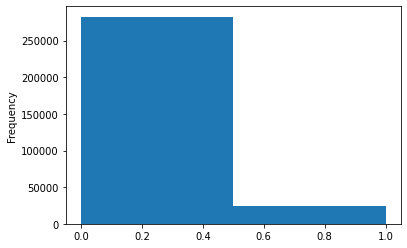

In [5]:
# Imbalence
train_df.TARGET.value_counts(normalize=True , dropna=False).to_frame().style.background_gradient('cividis')
train_df['TARGET'].astype(int).plot.hist(bins=2)

In [6]:
train_df.CODE_GENDER.value_counts(normalize=True,dropna=False).to_frame().style.background_gradient('cividis') ;      # code : 1 : F  &  0 : M

# Imputer les données manquantes
- Nous avons utilisé le `SimpleImputer`, car c'est très lent avec KNNImputer et IterativeImputer.
- Nous avons pris `10%` des données dans `train_df` pour test un autre modèle de classification.

In [7]:
# On entraine le modèle d'abord avec 20% des données
sample_train_df = train_df.sample(int(len(train_df) * 0.2))
print("sample_train_df Shape:{}".format(sample_train_df.shape))

sample_train_df Shape:(61501, 798)


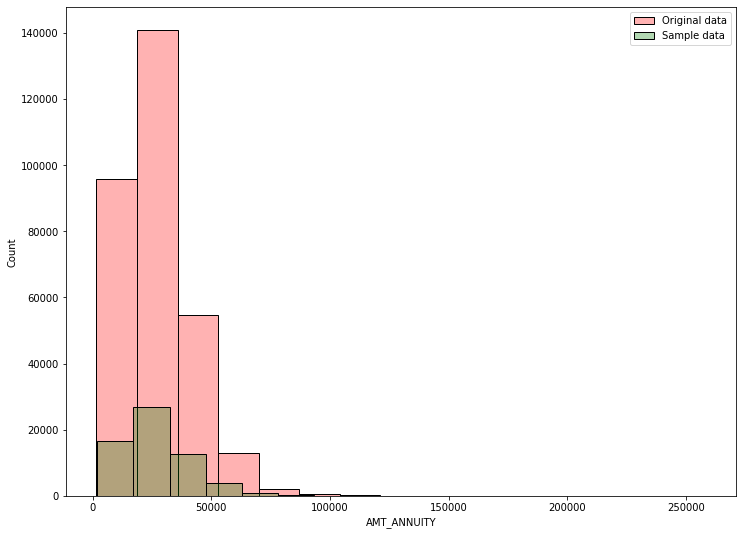

In [8]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 9))

sns.histplot( data=train_df, x="AMT_ANNUITY", label="Original data", color="red", alpha=0.3, bins=15)
sns.histplot(data=sample_train_df, x="AMT_ANNUITY", label="Sample data", color="green", alpha=0.3, bins=15)

plt.legend()
plt.show();

<AxesSubplot:>

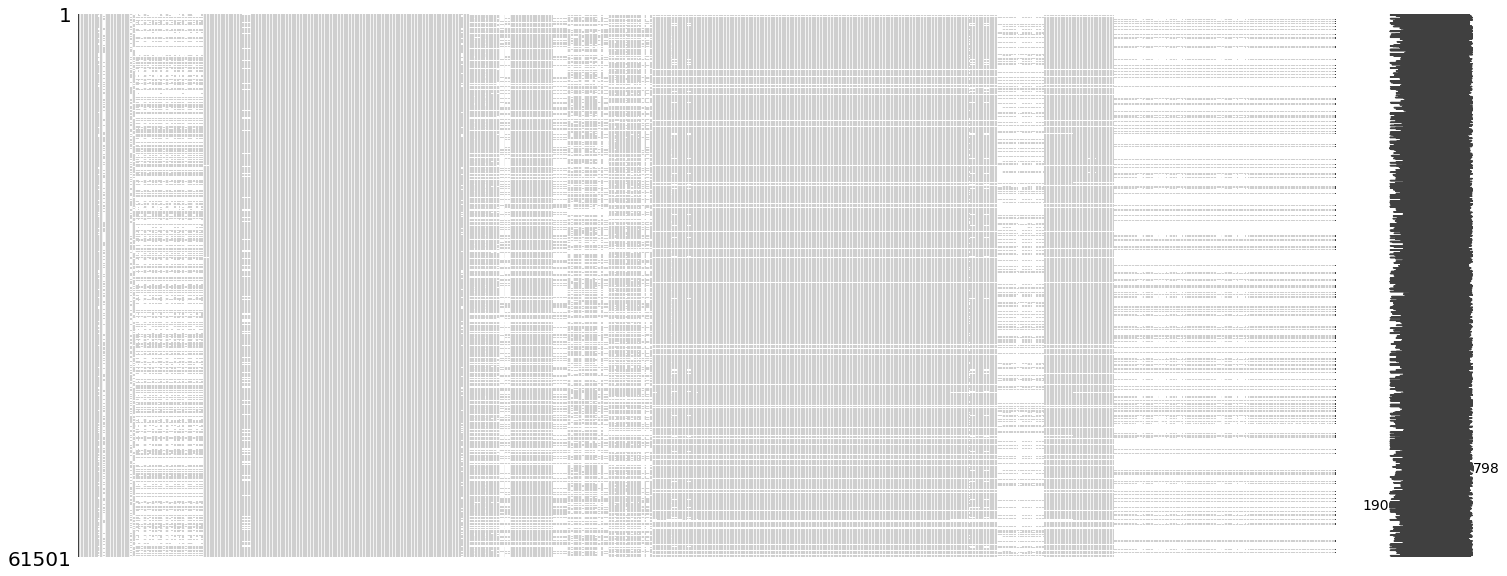

In [11]:
import missingno as msno
# les valeurs manquantes avec des lignes vides et les valeurs non manquantes avec des lignes noires.
msno.matrix(sample_train_df)

In [9]:
# Imputer les valeurs manquantes 
# Imputing with SimpleImputer
from sklearn.impute import SimpleImputer
most_imputer = SimpleImputer(strategy='most_frequent')
sample_train_df =pd.DataFrame(most_imputer.fit_transform(sample_train_df), 
                              columns=sample_train_df.columns)

/home/ying/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ying/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [13]:
sample_train_df.isna().mean();

# Modele
- La variable y est une variable catégorielle binaire avec des valeurs 0 et 1 et qu'il y a 92 % de zéros et 8 % de uns,
- La méthode train_test_split avec son option `stratify=y` s'assurera que la répartition aléatoire contient 92 % de 0's et 8 % de 1's.

In [10]:
# Sépartaion des données
feats = [f for f in sample_train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = sample_train_df[feats]
y = sample_train_df.TARGET
print("X shape: {}, y shape: {}".format(X.shape, y.shape))

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=1121218)

X shape: (61501, 795), y shape: (61501,)


# Modèle de base : DummyClassifier

In [15]:
from sklearn.dummy import DummyClassifier

# no skill model, stratified random class predictions
# Init classifier
model_dummy = DummyClassifier(strategy='stratified')

# Fit 
model_dummy.fit(X_train,y_train)

# predict
preds= model_dummy.predict_proba(X_valid)

# Score
#print("No Skil AUC : %.4f "% roc_auc_score(y_valid, preds))
print("No Skil AUC(preds_proba) : %.4f "% roc_auc_score(y_valid, preds[:, 1]))

No Skil AUC(preds_proba) : 0.5027 


# Modele : CatBoostClassifier

In [11]:
%%time

from catboost import CatBoostClassifier 
from sklearn.metrics import roc_auc_score

from sklearn.metrics import fbeta_score

# Init Classifier
model_CBC = CatBoostClassifier(loss_function = 'MultiClass', iterations=300, learning_rate=0.1, random_seed=123) 

# Fit
model_CBC.fit(X_train, y_train, verbose=False, plot=False)
#model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)

# Predict => predict_proba : (n_échantillons, n_classes)
preds = model_CBC.predict_proba(X_valid)

# Score
print("CatBoostClassifier AUC : %.4f "% roc_auc_score(y_valid, preds[:, 1]))

# AUC = 0.7728
# observation : On voit que, Le CatBoostClassifier est plus efficaces que le DummyClassifer.

CatBoostClassifier AUC : 0.7570 
CPU times: user 4min 9s, sys: 4.31 s, total: 4min 14s
Wall time: 55 s


In [14]:
# Enregistrer le modèle
dump(model_CBC,'model_CBC.joblib')

['model_CBC.joblib']

# HavingGridSearchCV

In [17]:
%%time

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# construction des dictionnaires d’hyperparamètres en donnant une nouvelle intervalle des paramètes
param_grid = {  "loss_function": ['MultiClass'],
                "learning_rate": [0.1,0.2],
                "iterations": [300, 400],
                #"logging_level" :['Verbose']
            }
# Init the estimater
halving_cv = HalvingGridSearchCV(model_CBC, param_grid, scoring="roc_auc", min_resources="exhaust", factor = 4)

# Fit
halving_cv.fit(X_train, y_train)

In [ ]:
# affichage des AUC pour la combinaison obtenant
print("Full AUC score:", halving_cv.best_score_, '\n')

# les meilleurs résultats
best_params = halving_cv.best_params_

print("Enregistrer les meilleurs paramètres pour CatBoostClassifier...")
best_params

AUC - RF: 0.7732168385726087 

Enregistrer les meilleurs paramètres pour CatBoostClassifier...


{'iterations': 400, 'learning_rate': 0.1, 'loss_function': 'MultiClass'}

## Construire les modèles avec les meilleurs paramètres. 
- Puis on entregistre le modèle.
- AUC - RF: 0.7516000165609498
- Meilleurs paramètres RF: {'iterations': 300, 'learning_rate': 0.1, 'loss_function': 'MultiClass'}


In [ ]:
#Créons un classificateur final avec les paramètres ci-dessus : 
final_CBC =CatBoostClassifier(**halving_cv.best_params_)

# Fit
final_CBC.fit(X_train, y_train, verbose=False, plot=False)

# Predict => predict_proba : (n_échantillons, n_classes)
preds =final_CBC.predict_proba(X_valid)

# Score
print("CatBoostClassifier AUC : %.4f "% roc_auc_score(y_valid, preds[:, 1]))

CatBoostClassifier AUC : 0.7763 


In [ ]:
## Crosse validation

In [ ]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
folds = KFold(n_splits= 10, shuffle=True, random_state=1001)

oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])


# split(X,y=None, groups = None)  => X : X, y =>train_df['TARGET]  
# X = X;  train_f[TARGER] =y
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
        train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]


        clf = final_CBC

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

       
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
                   
       
       
        del clf,train_x, train_y, valid_x, valid_y
        gc.collect()
        
        
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds))
    

In [ ]:
final_CBC.get_params()

{'iterations': 400, 'learning_rate': 0.1, 'loss_function': 'MultiClass'}

In [ ]:
from joblib import dump
dump(final_CBC, './final_CatBoostClassifier.joblib')

['./final_CatBoostClassifier.joblib']

# Fonction de coût de métier
- Déterminer un seuil à partir duquel la proba calculée se transforme en classe 1
    - Choisissez Rappel si l'idée de faux positifs est bien meilleure que les faux négatifs, 
    - en d'autres termes, si l'occurrence de faux négatifs est inacceptable/intolérable , que vous préféreriez obtenir des faux positifs supplémentaires (fausses alarmes) plutôt que d'enregistrer des faux négatifs, 

- 1 ->  positif  -> Fraude
- 0  -> negatif  -> Sans Fraude

- Pas bien : FN à minimiser

- Un ensemble de seuils différents est utilisé pour interpréter le taux de vrais positifs et le taux de faux positifs des prédictions sur la classe positive (minoritaire), et les scores sont tracés sur une ligne de seuils croissants pour créer une courbe.

In [ ]:
from joblib import load
model = load('./LGBMC.joblib')

In [ ]:
# Predict => predict_proba : (n_échantillons, n_classes)
preds =model.predict_proba(X_valid)

# Score
print("CatBoostClassifier AUC : %.4f "% roc_auc_score(y_valid, preds[:, 1]))

CatBoostClassifier AUC : 0.8262 


## Méthode 1 : Déterminer le seuil (thresholds) via `roc_curve`

In [ ]:
from sklearn.metrics import roc_curve,plot_roc_curve, balanced_accuracy_score

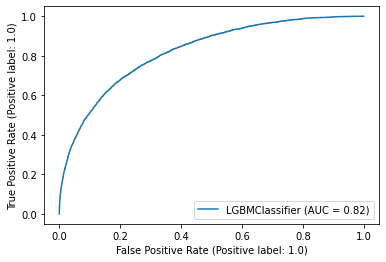

In [ ]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model,X_train,y_train)

In [ ]:
# fpr = précision & tpr =  recall
fpr, tpr, thresholds = roc_curve(y_valid,preds[:,1],drop_intermediate=False, pos_label =1)
fnr = 1 -tpr

fn = fnr*(sample_train_df.TARGET.value_counts(normalize=True)[1])
fp =fpr*(sample_train_df.TARGET.value_counts(normalize=True)[0])   # 0.92

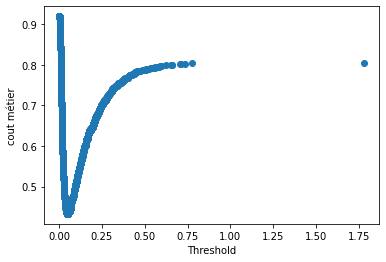

seuil : 0.0502107712251458
cout matier minimum :  0.4325672893579058


In [ ]:
plt.scatter(thresholds, (10*fn + fp))
plt.xlabel("Threshold")
plt.ylabel("cout métier")
plt.show()

threshold_min = thresholds[np.argmin(10*fn + fp)]
print("seuil :" , threshold_min)
print("cout métier minimum : ", min(10*fn + fp))
y_pred = [1 if x >= threshold_min else 0 for x in preds[:, 1]]


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# Create the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print("TN: {}   FP: {}   FN: {}   TP: {}".format(tn, fp, fn, tp),'\n')

print(metrics.classification_report(y_valid, y_pred, digits=3))

cost_metier = 10*fn + fp
print("coût métier :", cost_metier)

TN: 10939   FP: 3201   FN: 345   TP: 891 

              precision    recall  f1-score   support

         0.0      0.969     0.774     0.861     14140
         1.0      0.218     0.721     0.334      1236

    accuracy                          0.769     15376
   macro avg      0.594     0.747     0.597     15376
weighted avg      0.909     0.769     0.818     15376

coût métier : 6651


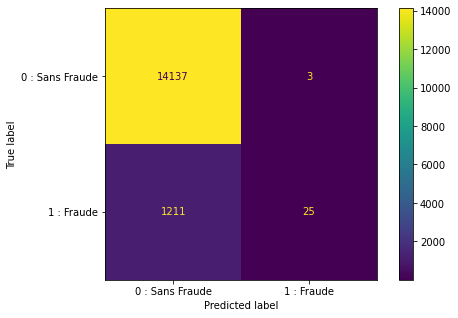

In [ ]:
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix( model,  # Fitted estimator (it must have been fit)
                      X_valid, y_valid,  # test sets
                      ax=ax,display_labels=["0 : Sans Fraude", "1 : Fraude"]
                      )

## Méthode 2 : Maximiser l'accuracy

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

precision, recall, thresholds = precision_recall_curve(y_valid, preds[:,1]) 

#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

In [ ]:
%%time

threshold = []
accuracy = []

for p in np.unique(preds[:,1]):
  threshold.append(p)
  y_pred = (preds[:,1] >= p).astype(int)
  accuracy.append(balanced_accuracy_score(y_valid,y_pred))

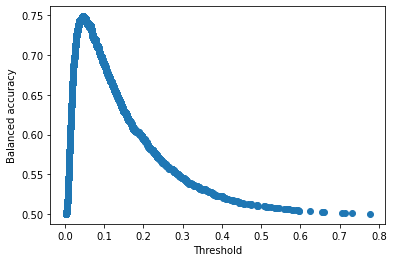

seuil : 0.04523209419198166


In [ ]:
plt.scatter(threshold, accuracy)
plt.xlabel("Threshold")
plt.ylabel("Balanced accuracy")
plt.show()

threshold_min = threshold[np.argmax(accuracy)]
print("seuil :" , threshold_min)

y_pred = [1 if x >= threshold_min else 0 for x in preds[:, 1]]

In [ ]:
from sklearn.metrics import confusion_matrix
# Create the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print("TN: {}   FP: {}   FN: {}   TP: {}".format(tn, fp, fn, tp),'\n')

print(metrics.classification_report(y_valid, y_pred, digits=3))

cost_metier = 10*fn + fp
print("coût métier :", cost_metier)

# F2-Score (beta=2) : Less weight on precision, more weight on recall
#f2 = fbeta_score(y_valid, y_pred, average = 'weighted', beta=2) # option : average='weighted'/ 'micro' / ('macro' : pas de déséquilibre)
#print("F2-Mesure: %.4f "% f2)

TN: 10464   FP: 3676   FN: 299   TP: 937 

              precision    recall  f1-score   support

         0.0      0.972     0.740     0.840     14140
         1.0      0.203     0.758     0.320      1236

    accuracy                          0.741     15376
   macro avg      0.588     0.749     0.580     15376
weighted avg      0.910     0.741     0.799     15376

coût métier : 6666


La ligne de fond est
— Une valeur de précision de 90 % signifie qu'une étiquette sur 10 est incorrecte et que 9 est correcte.
— Une valeur de précision de 80 % signifie qu'en moyenne, 2 élèves étiquetés diabétiques sur 10 par notre programme sont en bonne santé et 8 sont diabétiques.
— La valeur de rappel est de 70 % signifie que 3 personnes diabétiques sur 10 sont en réalité manquées par notre programme et 7 étiquetées comme diabétiques.
— La valeur de spécificité est de 60 % signifie que 4 personnes en bonne santé sur 10 sont en réalité mal étiquetées comme diabétiques et 6 sont correctement étiquetées comme étant en bonne santé.

In [ ]:
threshold_step =threshold_min 

bc.predicted_proba_violin_plot(true_y = y_valid,
                               predicted_proba = preds[:,1], 
                               threshold_step = threshold_step)

In [ ]:
threshold_step = threshold_min
curve_type = 'kde' #'kde' is the default value, can also be set to 'normal'

bc.predicted_proba_density_curve_plot(true_y = y_valid, 
                                      predicted_proba = preds[:, 1], 
                                      threshold_step = threshold_step,
                                      curve_type = curve_type)

# Feautre importance

In [ ]:
# final_CBC
fi_df = pd.DataFrame()
fi_df["feature_names"] = feats
fi_df["importance"] = model.feature_importances_
fi_df.sort_values(by="importance" , ascending=False)[:20]

feature_names  importance
244                    PAYMENT_RATE        1099
30                     EXT_SOURCE_1         985
32                     EXT_SOURCE_3         956
31                     EXT_SOURCE_2         881
9                        DAYS_BIRTH         704
6                       AMT_ANNUITY         566
10                    DAYS_EMPLOYED         492
578       APPROVED_CNT_PAYMENT_MEAN         419
308          ACTIVE_DAYS_CREDIT_MAX         415
12                  DAYS_ID_PUBLISH         399
240              DAYS_EMPLOYED_PERC         397
650   INSTAL_DAYS_ENTRY_PAYMENT_MAX         396
243             ANNUITY_INCOME_PERC         382
7                   AMT_GOODS_PRICE         376
311  ACTIVE_DAYS_CREDIT_ENDDATE_MIN         365
630                 INSTAL_DPD_MEAN         358
5                        AMT_CREDIT         332
11                DAYS_REGISTRATION         327
389           PREV_CNT_PAYMENT_MEAN         321
649          INSTAL_AMT_PAYMENT_SUM         310

In [ ]:
feats = [f for f in test_df.columns if f not in ['TARGET','index','SK_ID_CURR']] #,'SK_ID_BUREAU','SK_ID_PREV']]

model = load("LightGBMC.joblib")



In [ ]:
feature_importance = model.feature_importances_
feature_names = np.array(test_df[feats].columns)

In [ ]:

import plotly.express as px
def plot_feature_importance():
    #X= test_df.loc[test_df.SK_ID_CURR== id, feats]
    #feat_importances = pd.Series(model.feature_importances_, index = X.columns).sort_values(ascending = True)[:20]
    feature_importance = model.feature_importances_
    feature_names = np.array(test_df[feats].columns)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Plot Searborn bar chart
    fig = px.histogram(fi_df, x=fi_df['feature_importance'], y=fi_df['feature_names'])
    fig.show()

In [ ]:
plot_feature_importance()

In [ ]:
import plotly.express as px
df = px.data.tips()
fig = px.histogram(df, x="total_bill", y="tip", histfunc="avg", nbins=8, text_auto=True)
fig.show()

# SHAP
- explain the model's predictions using SHAP

In [ ]:
from joblib import load
model = load('./LightGBMC.joblib')

In [ ]:
%%time

# Shap values with LightGBM core moedl
preds = model.predict_proba(X_train, pred_contrib= True)


CPU times: user 16min 7s, sys: 3.58 s, total: 16min 10s
Wall time: 2min 22s


In [ ]:


#model = final_CBC
feat_names = list(X_train.columns)

# test
row1 = np.random.randint(X_train.shape[0])
row2 = np.random.randint(X_train.shape[0])
test_1 = X_train.iloc[row1]
test_2 = X_train.iloc[row2]
print(row1, row2)

42081 7009


In [ ]:
%%time 
import shap
shap.initjs() 
# explain the model's predictions using SHAP
# Create a tree explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:
import pandas as pd

In [ ]:
test_1["AMT_CREDIT"]

398016.0

In [ ]:
tmp = pd.DataFrame(shap_values[1], columns = X_train.columns)
tmp.head()

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0     0.224816      0.012100         0.002066     -0.000075         -0.004673   
1     0.106835     -0.004987        -0.003216     -0.000070          0.017186   
2    -0.099676      0.002801        -0.002051     -0.000065          0.001136   
3     0.131311      0.007571        -0.003783     -0.000113         -0.006340   
4     0.123503     -0.012615         0.000626     -0.000105         -0.007360   

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0    0.125410     0.114688         0.032556                   -0.056941   
1    0.045869    -0.000817         0.006314                    0.017836   
2   -0.042931     0.007091        -0.068732                   -0.056133   
3    0.001355    -0.045892        -0.029586                   -0.050411   
4   -0.089940    -0.181645         0.066446                    0.015583   

   DAYS_BIRTH  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0    0.045526  ...                                 0.0   
1    0.066532  ...                                 0.0   
2   -0.033805  ...                                 0.0   
3    0.000981  ...                                 0.0   
4    0.023619  ...                                 0.0   

   CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                  0.0                                 0.0   
1                                  0.0                                 0.0   
2                                  0.0                                 0.0   
3                                  0.0                                 0.0   
4                                  0.0                                 0.0   

   CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                            0.000796                              0.0   
1                            0.000640                              0.0   
2                            0.000994                              0.0   
3                            0.000848                              0.0   
4                            0.000666                              0.0   

   CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              0.0                               0.0   
4                              0.0                               0.0   

   CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              0.0                              0.0 -0.000737  
1                              0.0                              0.0 -0.001275  
2                              0.0                              0.0 -0.000687  
3                              0.0                              0.0 -0.000288  
4                              0.0                              0.0 -0.000785  

[5 rows x 795 columns]

### Exlications globales

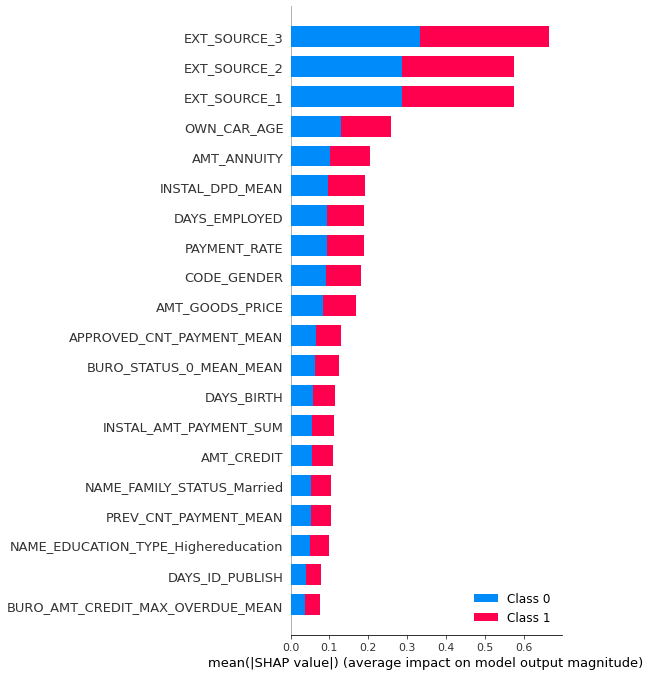

In [ ]:
shap.summary_plot(shap_values, features=feat_names)

### Explication la classe 1

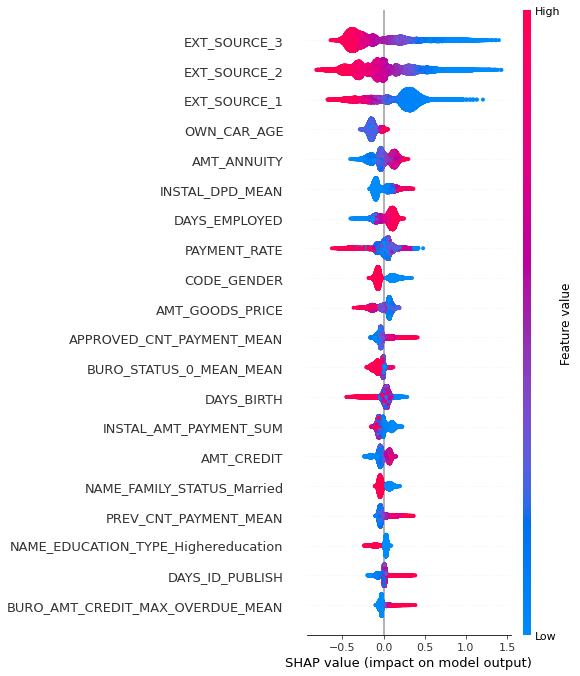

In [ ]:
shap.summary_plot(shap_values[1], X_train.values, feature_names = feat_names)

### Explication la classe 0

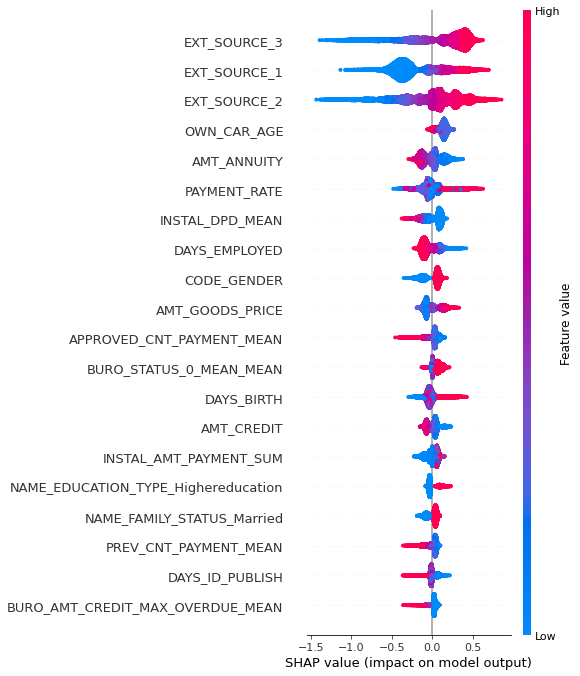

In [ ]:
shap.summary_plot(shap_values[0], X_train.values, feature_names = feat_names)
# Contraire à celui en haut

### Explication des premiers 100 individus dans la classe 1

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:100,:], X_train.iloc[:100,:])

### Explications locals : test 1 : row1

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][row1], test_1, feature_names =feat_names )

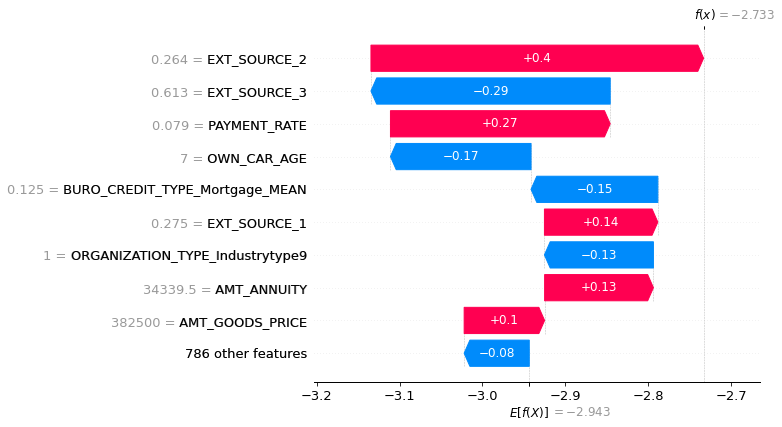

In [ ]:
# Le diagramme en cascade
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row1], 
                                              base_values=explainer.expected_value[1], data=test_1,  
                                         feature_names = feat_names))

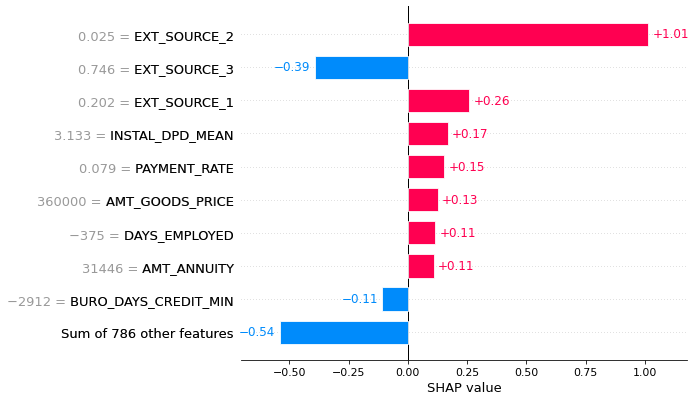

In [ ]:
# Le diagramme à barres est centré sur zéro pour montrer les contributions des variables
shap.plots.bar(shap.Explanation(values=shap_values[1][row1], 
                                              base_values=explainer.expected_value[1], data=test_1,  
                                         feature_names = feat_names))

The expected value is  -2.9434716034587263


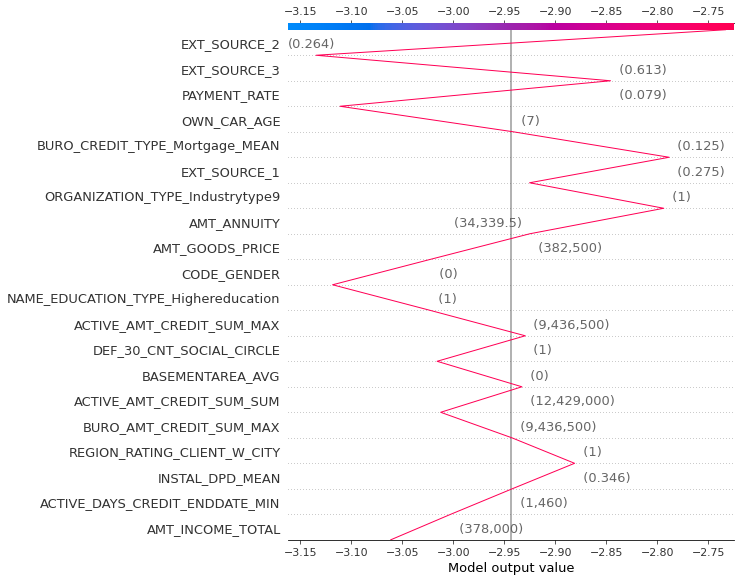

In [ ]:
print("The expected value is ", explainer.expected_value[1])
shap.decision_plot( explainer.expected_value[1], shap_values[1][row1], test_1, feature_names=feat_names)

### Explications locals : test : row2

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][row2], test_2, feature_names =feat_names )

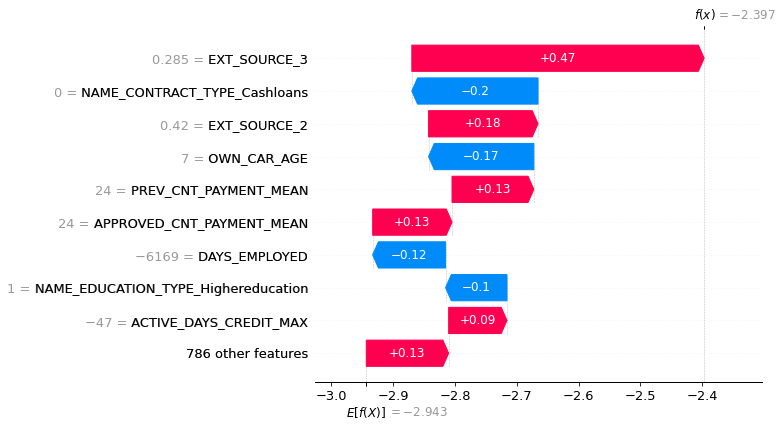

In [ ]:
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row2], 
                                              base_values=explainer.expected_value[1], data=test_2,  
                                         feature_names = feat_names))

The expected value is  -2.9434716034587263


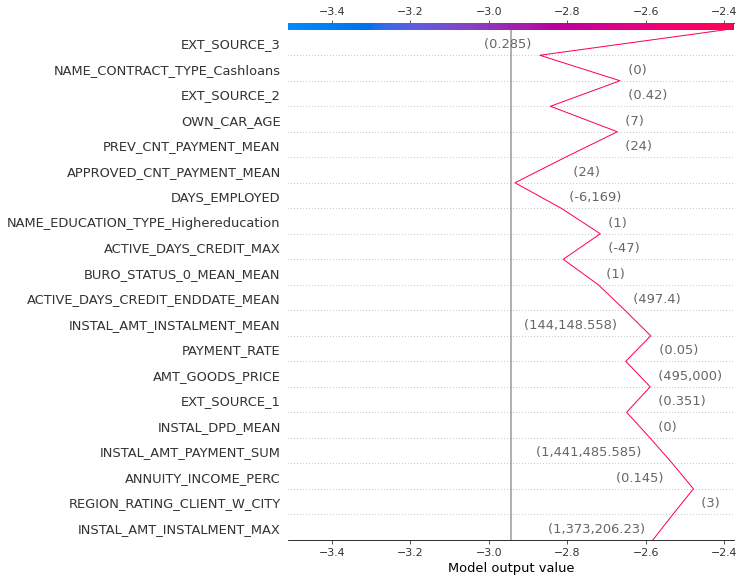

In [ ]:
print("The expected value is ", explainer.expected_value[1])
shap.decision_plot( explainer.expected_value[1], shap_values[1][row2], test_2, feature_names=feat_names)

In [ ]:
print("Valeur de base pour la classe 0 : {} ".format( explainer.expected_value[0]))
print("Valeur de base pour la classe 1 : {} ".format( explainer.expected_value[1]))

Valeur de base pour la classe 0 : 2.9434716034587263 
Valeur de base pour la classe 1 : -2.9434716034587263 


In [ ]:
val0 = explainer.expected_value[0]+ shap_values[0][row1].sum()
val1 = explainer.expected_value[1]+ shap_values[1][row1].sum()

print("Prédiction de l'ajout de valeurs SHAP à la valeur de base : class {}" .format(np.argmax([val0,val1])))

Prédiction de l'ajout de valeurs SHAP à la valeur de base : class 0


In [ ]:
val0 = explainer.expected_value[0]+ shap_values[0][row2].sum()
val1 = explainer.expected_value[1]+ shap_values[1][row2].sum()

print("Prédiction de l'ajout de valeurs SHAP à la valeur de base : class {}" .format(np.argmax([val0,val1])))

Prédiction de l'ajout de valeurs SHAP à la valeur de base : class 0


In [ ]:
test_1["PAYMENT_RATE"]

0.07900687409551375

In [ ]:
X_train["PAYMENT_RATE"].max()

0.12442957597804374

In [ ]:

application_test_df= dt.fread("application_test.csv", sep=",").to_pandas()

In [ ]:
application_test_df.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

In [ ]:
application_test_df.iloc[row1]['AMT_INCOME_TOTAL']

270000.0

In [ ]:
X_train.iloc[row1]['AMT_INCOME_TOTAL']

67500.0

In [ ]:

feats = [f for f in test_df.columns if f not in ['TARGET','index', 'SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]

In [ ]:

shap_values_test = explainer.shap_values(test_df[feats])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:
tmp_test = pd.DataFrame(shap_values_test[1], columns = feats)
shap_class_1_df = tmp_test.join(test_df["SK_ID_CURR"], how='right')
shap_class_1_df.to_csv("shap_class_1_df.csv",index=False)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0    -0.069000      0.004958         0.002658      0.000112         -0.002977   
1     0.225295      0.016674         0.002411      0.000119          0.000186   
2     0.159246     -0.004315         0.000528     -0.000059          0.006900   
3    -0.058548      0.002417         0.004919     -0.000677          0.004874   
4     0.085745     -0.007918        -0.002234      0.000029          0.011309   

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0    0.011992    -0.054174         0.078118                    0.019299   
1   -0.057977    -0.056452         0.123885                    0.010703   
2    0.057303     0.122356        -0.012516                    0.036865   
3    0.085724     0.141061        -0.181655                    0.049333   
4    0.015189     0.141687        -0.007977                   -0.016659   

   DAYS_BIRTH  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0   -0.045047  ...                                 0.0   
1    0.019094  ...                                 0.0   
2   -0.049848  ...                                 0.0   
3    0.023105  ...                                 0.0   
4    0.062405  ...                                 0.0   

   CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                  0.0                                 0.0   
1                                  0.0                                 0.0   
2                                  0.0                                 0.0   
3                                  0.0                                 0.0   
4                                  0.0                                 0.0   

   CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                            0.001095                              0.0   
1                            0.000985                              0.0   
2                            0.001221                              0.0   
3                            0.000232                              0.0   
4                            0.000765                              0.0   

   CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              0.0                               0.0   
4                              0.0                               0.0   

   CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              0.0                              0.0 -0.000099  
1                              0.0                              0.0 -0.000039  
2                              0.0                              0.0 -0.000292  
3                              0.0                              0.0  0.000027  
4                              0.0                              0.0 -0.000080  

[5 rows x 795 columns]

In [ ]:
id = 100005
test_idx = test_df.loc[test_df["SK_ID_CURR"]== id].index
test_df.iloc[test_idx]

Int64Index([1], dtype='int64')

In [ ]:
    #Plot Searborn bar chart
shap.waterfall_plot(shap.Explanation(values=shap_values_test[1][test_idx], 
                              base_values=explainer.expected_value[1], data = test_df.iloc[test_idx][feats],  
                             feature_names = feats))

Exception: The waterfall_plot can currently only plot a single explanation but a matrix of explanations was passed!